In [182]:
import pandas as pd
import nltk
from nltk.corpus import inaugural, stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import glob
%matplotlib inline

In [183]:
df = pd.read_csv('./PresidentialDataFrame.csv', index_col=0)

In [184]:
#not used
df.drop('Wiki References', axis=1, inplace=True)

In [185]:
df.tail()

,First Year of Presidency,President Name,Wiki Content,Num Wiki References,Words on Page
39,1989,George H. W. Bush,"George Herbert Walker Bush (born June 12, 1924...",344,88238
40,1993,Bill Clinton,"William Jefferson ""Bill"" Clinton (born William...",392,73712
41,2001,George W. Bush,"George Walker Bush (born July 6, 1946) is an A...",787,88626
42,2009,Barack Hussein Obama,Barack Hussein Obama II ( ( listen); born Augu...,882,84498
43,2017,Donald Trump,"Donald John Trump (born June 14, 1946) is the ...",726,88048


In [186]:
#accessing the inaugural addresses of all Presidents
addresses = {}
for file in inaugural.fileids():
    if file in ['1825-Adams.txt', '1933-Roosevelt.txt', '1937-Roosevelt.txt', '1941-Roosevelt.txt', '1945-Roosevelt.txt',
               '2001-Bush.txt', '2005-Bush.txt',  '1889-Harrison.txt', '1965-Johnson.txt']:
        name = file[5:-4] + '2'
        if name in addresses:
            addresses[name] += list(inaugural.words(file))
        else:
            addresses[name] = list(inaugural.words(file))
    else:
        name = file[5:-4]
        if name in addresses:
            addresses[name] += list(inaugural.words(file))
        else:
            addresses[name] = list(inaugural.words(file))

In [187]:
#Missing Trump's first and Obama's second, van buren's first- adding them here
obama = open('./obama2.txt').read()
obama = obama.split()
addresses['Obama'].extend(obama)

trump = open('./trump_in.txt').read()
trump = trump.split()
addresses['Trump'] = trump

buren = open('./van_buren.txt').read()
buren = buren.split()
addresses['Buren'] = buren

In [188]:
#getting last names to merge on
last_names = [val.split()[-1] for val in df['President Name']]
cleaned = []
for val in last_names:
    if val not in cleaned:
        cleaned.append(val)
    else:
        val = val + '2'
        cleaned.append(val)

In [189]:
df['for_merge'] = cleaned

In [190]:
#making a df to merge
address = pd.DataFrame()
address['Inaugural'] = list(addresses.values())
address['name'] = list(addresses.keys())

In [191]:
#Presidents that never delivered an inaugural address
set(df['for_merge']) - set(address['name'])

{'Arthur', 'Fillmore', 'Ford', 'Johnson', 'Tyler'}

In [192]:
df = pd.merge(df, address, how='left', left_on='for_merge', right_on='name')

In [193]:
#selfishness over time
#Teddy Roosevelet the only President not to say 'I' in his inaugural address
#NO 'me', TR, Obama, Trump, George H.W. Bush, Coolidge, JFK
#all used 'my'
selfish = df.dropna()
selfish = selfish.reset_index(drop=True)
cfd = nltk.ConditionalFreqDist((word.lower(),num) for num, file in enumerate(selfish['Inaugural']) for word in file 
                        if word.lower() in ['i', 'me', 'my'])

#creating lists and filling in missing values
i_use = list(cfd['i'].values())
i_use.insert(20, 0)

me_use = list(cfd['me'].values())
me_use.insert(38, 0)
me_use.insert(37, 0)
me_use.insert(34, 0)
me_use.insert(29, 0)
me_use.insert(24, 0)
me_use.insert(20, 0)

my_use = list(cfd['my'].values())

#getting the percentage use for each word by year/president
i_use = np.array(i_use) / np.array([len(val) for val in selfish['Inaugural']])
me_use = np.array(me_use) / np.array([len(val) for val in selfish['Inaugural']])
my_use = np.array(my_use) / np.array([len(val) for val in selfish['Inaugural']]) 

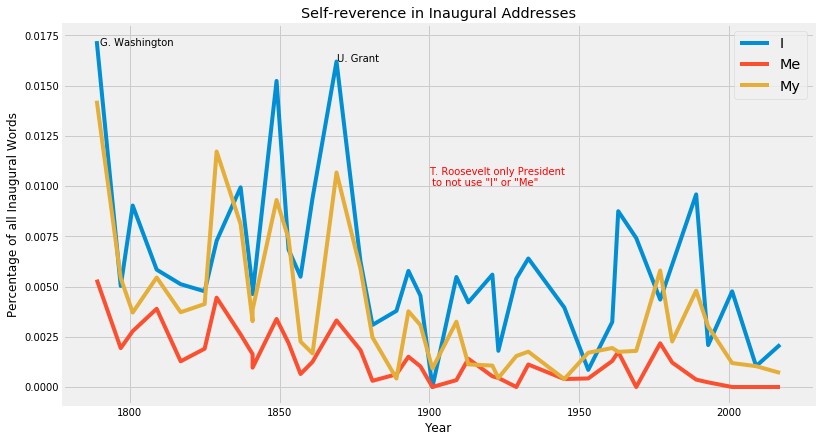

In [194]:
plt.figure(figsize=(12,7))
plt.plot(selfish['First Year of Presidency'], i_use, label='I')
plt.plot(selfish['First Year of Presidency'], me_use, label='Me')
plt.plot(selfish['First Year of Presidency'], my_use, label='My')
plt.ylabel('Percentage of all Inaugural Words')
plt.xlabel('Year')
plt.title('Self-reverence in Inaugural Addresses')
plt.text(1790, 0.017,'G. Washington')
plt.text(1869, 0.0162, 'U. Grant')
plt.text(1900, 0.01, 'T. Roosevelt only President \n to not use "I" or "Me"', color='red')
plt.legend(fontsize='x-large')

In [195]:
#including a measure of CSPANS president ranking (https://www.c-span.org/presidentsurvey2017/?page=overall)
cspan_order = ['Abraham Lincoln ','George Washington ','Franklin D. Roosevelt ','Theodore Roosevelt ','Dwight D. Eisenhower ','Harry S. Truman ','Thomas Jefferson ','John F. Kennedy ','Ronald Reagan ','Lyndon Baines Johnson ','Woodrow Wilson ','Barack Obama ','James Monroe  ','James K. Polk ','Bill Clinton  ','William McKinley','James Madison  ','Andrew Jackson  ','John Adams ','George H. W. Bush ','John Quincy Adams ','Ulysses S. Grant  ','Grover Cleveland  ','William H. Taft ','Gerald R. Ford','Jimmy Carter  ','Calvin Coolidge ','Richard M. Nixon ','James A. Garfield  ','Benjamin Harrison  ','Zachary Taylor  ','Rutherford B. Hayes ','George W. Bush ','Martin Van Buren  ','Chester Arthur  ','Herbert Hoover  ','Millard Fillmore   ','William Henry Harrison  ','John Tyler  ','Warren G. Harding ','Franklin Pierce','Andrew Johnson','James Buchanan ']
cspan = pd.DataFrame()
cspan['name'] = cspan_order
cspan = cspan.reset_index()
cspan.columns = ['rank', 'name']

#getting last names for merge
new_names = []
for val in list(cspan['name'].str.split().str[-1]):
    if val not in new_names:
        new_names.append(val)
    else:
        new_val = val + '2'
        new_names.append(new_val)

#fixing mixed last names
new_names[2] = 'Roosevelt2'
new_names[3] = 'Roosevelt'
new_names[29] = 'Harrison2'
new_names[37] = 'Harrison'
new_names[9] = 'Johnson2'
new_names[41] = 'Johnson'

cspan['name'] = new_names
#fixing for 0 rank
cspan['rank'] = cspan['rank'].shift(-1).fillna(43)

In [196]:
df = pd.merge(df, cspan, how='left', left_on='for_merge', right_on='name')

In [197]:
#dropping redundant name columns
df.drop(['name_x','name_y', 'for_merge'], axis=1, inplace=True)

In [198]:
#getting birth and death years
birth = []
death = []

for val in df['Wiki Content']:
    births = re.search(r'\d{4}', val)
    birth.append(births.group(0))
    deaths = re.search('\d{4}(?=\))', val)
    death.append(deaths.group(0))
    
df['birth_year'] = birth
df['death_year'] = death

#changing Presidents who are still alive to Null
df.loc[df.birth_year == df.death_year, 'death_year'] = np.nan

In [199]:
#creating life span
df['years_lived'] = df['death_year'].fillna(0).astype(int) - df['birth_year'].astype(int)
df.loc[df['years_lived'] < 0, 'years_lived'] = np.nan

In [200]:
#converting data type
df['birth_year'] = df['birth_year'].astype(int)

In [201]:
#age became president
df['age_become_pres'] = df['First Year of Presidency'] - df['birth_year']

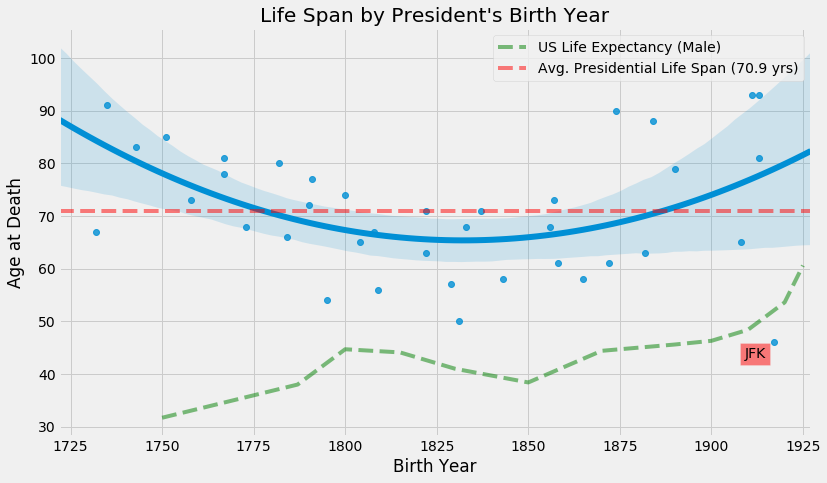

In [202]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))

sns.regplot(df['birth_year'], df['years_lived'], order=2)
plt.plot([1750, 1787, 1800, 1815, 1830, 1850, 1870, 1890, 1900, 1910, 1920, 1925] ,
         [31.7, 38, 44.7, 44.1, 41, 38.4, 44.4, 45.6, 46.3, 48.4, 53.6, 60.6], c='g', linestyle='dashed', alpha=0.5,
        label='US Life Expectancy (Male)')
plt.title('Life Span by President\'s Birth Year')
plt.ylabel('Age at Death')
plt.xlabel('Birth Year')
plt.axhline(df['years_lived'].mean(), color='r', linestyle='dashed', alpha=0.5, label='Avg. Presidential Life Span (70.9 yrs)')
plt.text(1909, 43, 'JFK', bbox=dict(facecolor='red', alpha=0.5))
plt.legend()

In [203]:
#collecting all dates in their wikipedia pages (will eliminate all not w/in 40 yrs of presidency to make robust to other 4 digit #s)
df['dates_in_wiki'] = df['Wiki Content'].apply(lambda x: np.array([np.int(i) for i in re.findall(r'\d{4}', x)]))

In [204]:
#differences between dates in wiki and first year of presidency 
df['date_diffs'] = df['dates_in_wiki']- df['First Year of Presidency']

#only interesed in events that occurred 40 years before/after Presidency (enough time to capture all relevant events)
df['date_diffs'] = df['date_diffs'].apply(lambda x: x[np.abs(x) < 40])

In [205]:
df['years_lived_after_pres'] = (df['years_lived'].fillna(0) + df['birth_year']) - df['First Year of Presidency']
df.loc[df['years_lived_after_pres'] < 0, 'years_lived_after_pres'] = np.nan

In [206]:
#getting the mean of the dates presented in the President's profile and their standard deviation
df['profile_dates_mean'] = df['date_diffs'].apply(lambda x: x.mean())
df['profile_dates_std'] = df['date_diffs'].apply(lambda x: x.std())

In [207]:
df.columns

Index(['First Year of Presidency', 'President Name', 'Wiki Content',
       'Num Wiki References', 'Words on Page', 'Inaugural', 'rank',
       'birth_year', 'death_year', 'years_lived', 'age_become_pres',
       'dates_in_wiki', 'date_diffs', 'years_lived_after_pres',
       'profile_dates_mean', 'profile_dates_std'],
      dtype='object')

In [208]:
#presidency length
df['presidency_length'] = df['First Year of Presidency'].diff().shift(-1)
#correcting for one non-contiguously serving President
df.loc[df['President Name'] == 'Grover Cleveland', 'presidency_length'] = 8.0

Text(0.5,1,'Page Length as a Function of Time')

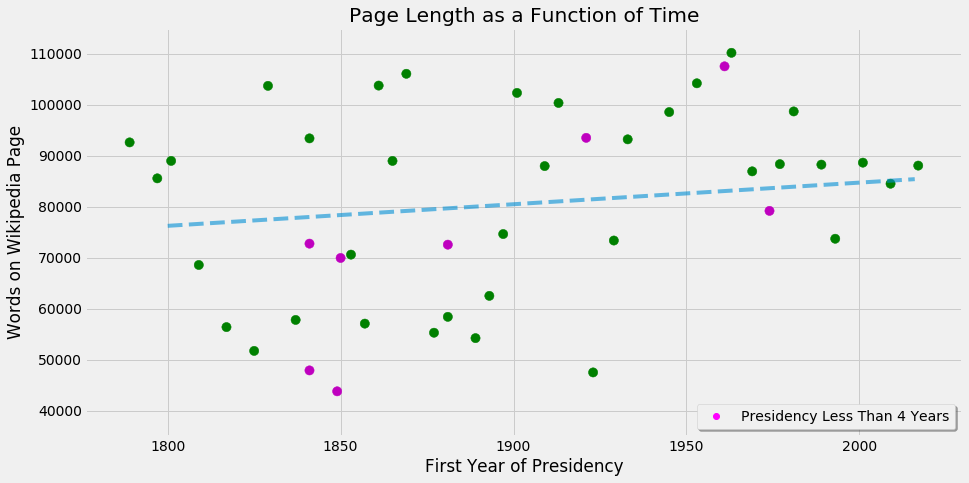

In [209]:
#for line of best fit
ols = sm.OLS(df['Words on Page'], df['First Year of Presidency'].values,).fit()
x = np.array([1800, 1850, 1900, 1950, 2016])
y = ols.params[0] * x

#plotting figure
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(14,7))
ax = plt.plot(x, y, alpha= 0.6, linestyle='dashed')
ax = plt.scatter(df['First Year of Presidency'], df['Words on Page'], c = 
                ['m' if x < 4 else 'g' for x in df['presidency_length']], s=85)
plt.ylim(35000, 115000)
line1 = plt.Line2D(range(1), range(1), color="magenta", marker='o', markerfacecolor="magenta", linewidth=0)
plt.legend(([line1]),(['Presidency Less Than 4 Years']),numpoints=1, loc='lower right', shadow=True)

plt.ylabel('Words on Wikipedia Page')
plt.xlabel('First Year of Presidency')
plt.title('Page Length as a Function of Time')

In [210]:
#creating the function to compare inaugural addresses with wiki pages
stop = stopwords.words('english')
stop.append(['day', 'owned', 'came', 'known', 'united', 'states', 'sent', 'american', 'america', 'later', 'one'])
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

def page_prep(page):
    """removing stop words, numbers, small, words, lemmatizing and other information not useful to document
    comparison"""
    no_nums = re.sub(r'[^a-zA-Z]', ' ', page).lower()
    tokens = tokenizer.tokenize(no_nums)
    no_small = [word for word in list(tokens) if len(word) > 2]
    no_stop = [lemmatizer.lemmatize(word) for word in no_small if word not in stop]
    return ' '.join(no_stop)

In [211]:
#converting lists into strings for preparation
replacements = []
for val in df['Inaugural']:
    if isinstance(val, float):
        replacements.append('')
    else: 
        new = ' '.join([i for i in val])
        replacements.append(new)
        
df['Inaugural'] = replacements

In [212]:
#applying the cleaning function
df['clean_wiki'] = df['Wiki Content'].apply(page_prep)
df['clean_inaug'] = df['Inaugural'].apply(page_prep)

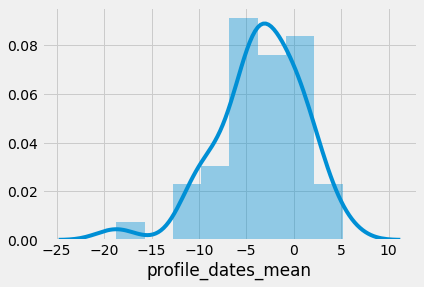

In [213]:
#havent eliminated living presidents yet- this is still biased negatively
sns.distplot(df['profile_dates_mean'], norm_hist=True)

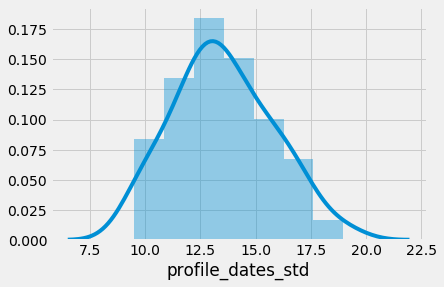

In [214]:
sns.distplot(df['profile_dates_std'], norm_hist=True)

(0, 50)

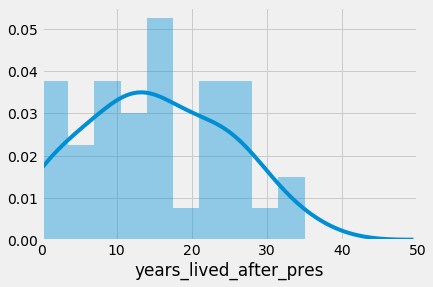

In [215]:
sns.distplot(df['years_lived_after_pres'].dropna(), bins=10)
plt.xlim(0, 50)

In [216]:
#PREPPING FOR wiki/inaugural similarity scores
pres_success = df.copy()
pres_success = pres_success[['President Name', 'clean_wiki', 'clean_inaug']]

#dropping nulls
print('Never delivered an inaugural: \n',pres_success.loc[np.where(pres_success['clean_inaug'] == '')]['President Name'])
pres_success = pres_success.drop(list(pres_success.loc[np.where(pres_success['clean_inaug'] == '')].index), axis=0).reset_index(drop=True)

Never delivered an inaugural: 
 9            John Tyler
12     Millard Fillmore
16       Andrew Johnson
20    Chester A. Arthur
36       Gerald R. Ford
Name: President Name, dtype: object


In [217]:
#creating the similarities
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
vectorizer.fit(pres_success['clean_inaug'])
y = vectorizer.transform(pres_success['clean_inaug'])
X = vectorizer.transform(pres_success['clean_wiki'])
similarities = pd.DataFrame((y * X.T).A)
similarities_inaug = pd.DataFrame((y * y.T).A)

In [218]:
#renaming columns/index with president names
similarities.columns = pres_success['President Name'].tolist()
similarities.index = pres_success['President Name'].tolist()
similarities_inaug.columns = pres_success['President Name'].tolist()
similarities_inaug.index = pres_success['President Name'].tolist()

In [219]:
#getting just similarity with themselves
success = pd.DataFrame(np.diag(similarities), index=pres_success['President Name'].tolist()).reset_index()
success.columns = ['name', 'cos_similarity_wiki_inaug']

#creating top/bottom for graphic
top_10_bottom_10 = success.sort_values(by='cos_similarity_wiki_inaug', ascending=False).head(10).append(success.sort_values(by='cos_similarity_wiki_inaug', ascending=False).tail(10))

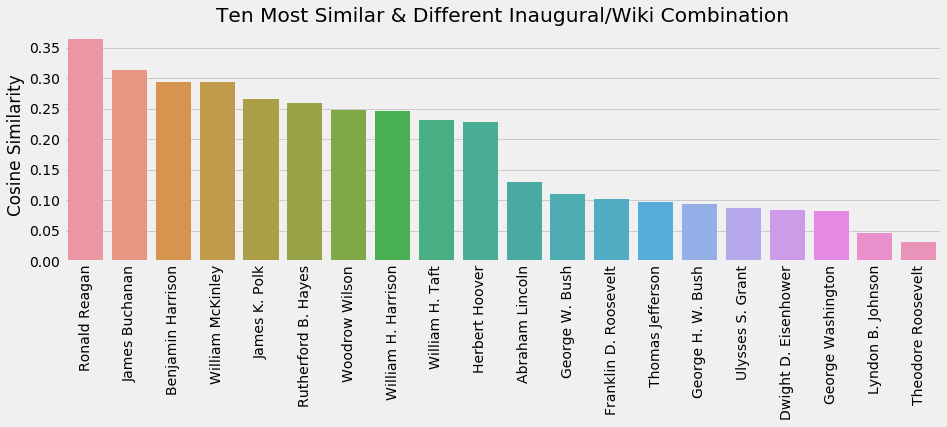

In [220]:
plt.figure(figsize=(14, 4))
sns.barplot(top_10_bottom_10['name'], top_10_bottom_10['cos_similarity_wiki_inaug'])
plt.xticks(rotation=90)
plt.title('Ten Most Similar & Different Inaugural/Wiki Combination')
plt.ylabel('Cosine Similarity')
plt.xlabel('');

In [221]:
#merging similarities
df = pd.merge(df, success, how='left', left_on='President Name', right_on='name')

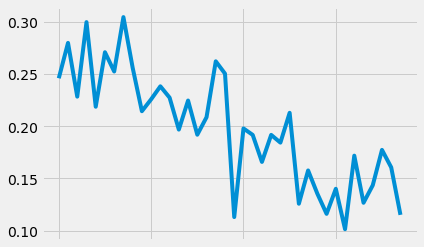

In [222]:
similarities_inaug['George Washington'].shift(-1).plot()

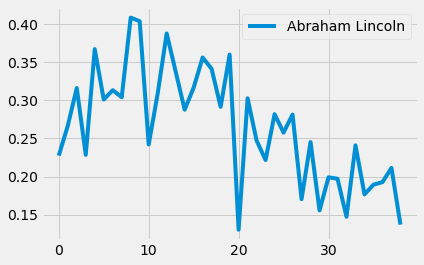

In [223]:
lincoln = similarities_inaug['Abraham Lincoln'].reset_index().drop(13)
lincoln.plot()

In [224]:
#creating dummy for war deaths
wars = pd.DataFrame(index=df['First Year of Presidency'].tolist())
wars['war_deaths'] = 0
wars = wars.reset_index()
#dummy variable for more than 10,000 war deaths during presidency
wars.loc[3]['war_deaths'] = 1
wars.loc[10]['war_deaths'] = 1
wars.loc[15]['war_deaths'] = 1
wars.loc[26]['war_deaths'] = 1
wars.loc[30]['war_deaths'] = 1
wars.loc[31]['war_deaths'] = 1
wars.loc[32]['war_deaths'] = 1
wars.loc[34]['war_deaths'] = 1
wars.loc[35]['war_deaths'] = 1

df['more_than_10000_deaths'] = wars['war_deaths'].values

In [225]:
#dropping redundant column
df = df.drop('name', axis=1)

In [226]:
df.columns

Index(['First Year of Presidency', 'President Name', 'Wiki Content',
       'Num Wiki References', 'Words on Page', 'Inaugural', 'rank',
       'birth_year', 'death_year', 'years_lived', 'age_become_pres',
       'dates_in_wiki', 'date_diffs', 'years_lived_after_pres',
       'profile_dates_mean', 'profile_dates_std', 'presidency_length',
       'clean_wiki', 'clean_inaug', 'cos_similarity_wiki_inaug',
       'more_than_10000_deaths'],
      dtype='object')

Text(0.5,1,'Page length and References')

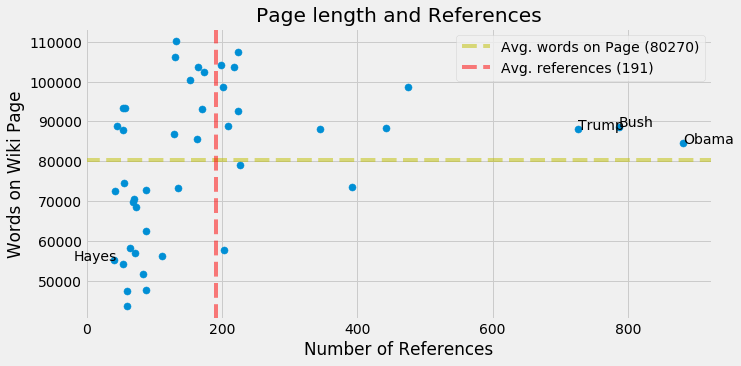

In [227]:
#impact of the number of references on page length
fig, ax = plt.subplots(figsize=(10,5))
references = df.sort_values(by='Num Wiki References')
fig = plt.scatter(references['Num Wiki References'], references['Words on Page'], label='', s=50)

#annotating minimum value and outliers
for num, val in enumerate(references['Num Wiki References']):
    if val > 600: 
        ax.annotate(references.iloc[num]['President Name'].split()[-1], xy=(references.iloc[num]['Num Wiki References'],
                                                          references.iloc[num]['Words on Page']),
                                                    xytext=(references.iloc[num]['Num Wiki References'],
                                                          references.iloc[num]['Words on Page']))
    if val == references['Num Wiki References'].min():
        ax.annotate(references.iloc[num]['President Name'].split()[-1], xy=(references.iloc[num]['Num Wiki References'],
                                                          references.iloc[num]['Words on Page']),
                                                    xytext=(references.iloc[num]['Num Wiki References'] - 60,
                                                          references.iloc[num]['Words on Page']))

plt.axhline(references['Words on Page'].mean(), label='Avg. words on Page ({:d})'.format(int(references['Words on Page'].mean())), c='y', linestyle='dashed', alpha=0.5)
plt.axvline(references['Num Wiki References'].mean(), label='Avg. references ({:d})'.format(int(references['Num Wiki References'].mean())), c='r', linestyle='dashed', alpha=0.5)
plt.legend()
plt.ylabel('Words on Wiki Page')
plt.xlabel('Number of References')
plt.title('Page length and References')
 

In [228]:
#turning the cosine similarities into rankings for ease of comparison
new_rank = df.copy()
new_rank = new_rank[['cos_similarity_wiki_inaug', 'President Name']]
new_rank = new_rank.sort_values(by='cos_similarity_wiki_inaug', ascending=False).reset_index(drop=True).reset_index()
new_rank['index'] = new_rank['index'] + 1
new_rank.columns = ['sim_rank', 'cos', 'name']
#making sure nulls are still listed as nulls
new_rank.loc[new_rank['cos'].isnull(), 'sim_rank'] = np.nan
new_rank = new_rank.drop('cos', axis=1)
#merging with old df
df = pd.merge(df, new_rank, left_on='President Name', right_on='name')
df = df.drop('name', axis=1)

In [229]:
#difference is enormous, probably not measuring successs
print('difference in ranks between cosine similarities and historians: ', 
      np.mean(np.abs(df['rank'] - df['sim_rank'])))

difference in ranks between cosine similarities and historians:  15.473684210526315


In [230]:
#converting column
df.death_year = df.death_year.fillna(0).astype(int)

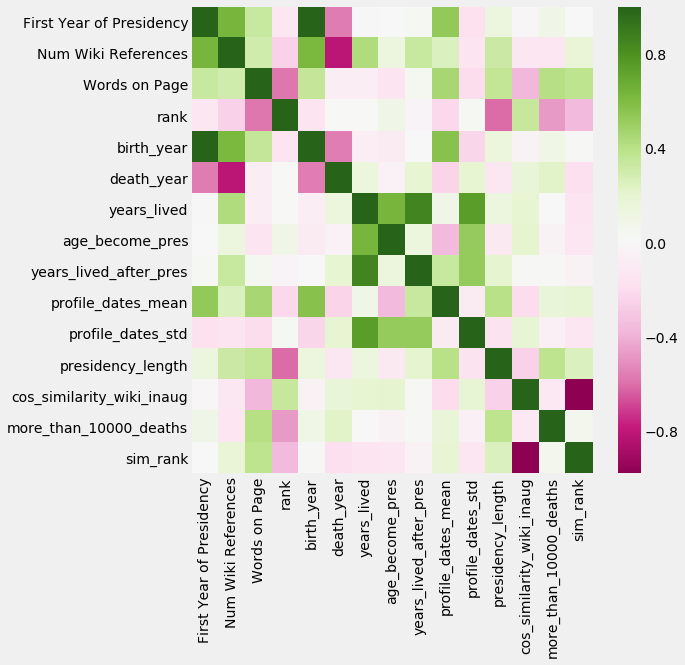

In [231]:
#heatmap for correlations across variables
fig, ax = plt.subplots(figsize=(8,8))
correlations = df.corr()
sns.heatmap(correlations, cmap='PiYG')

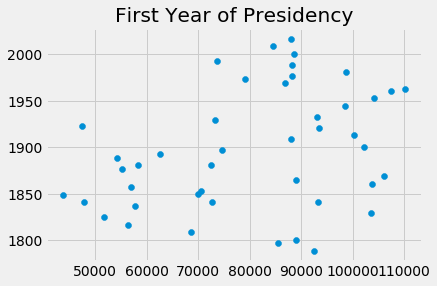

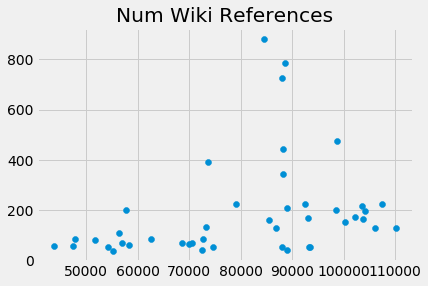

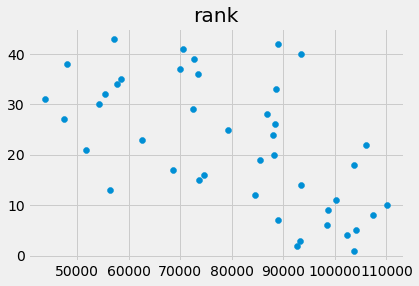

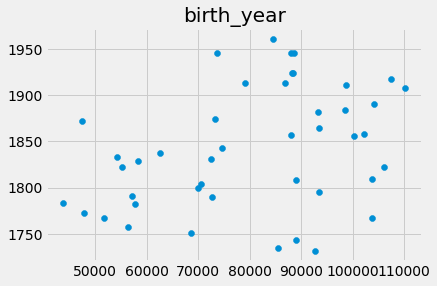

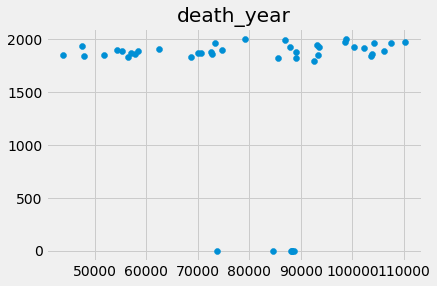

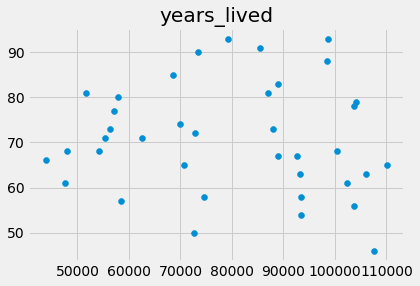

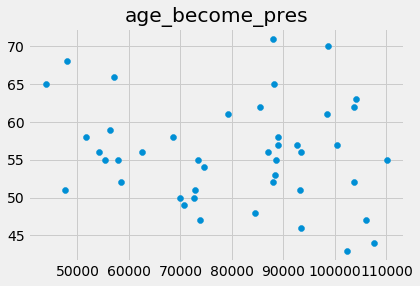

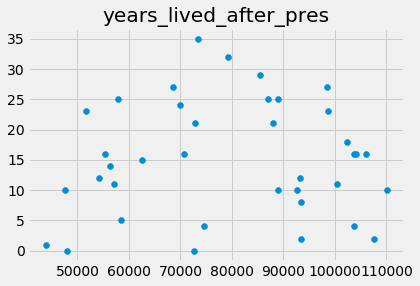

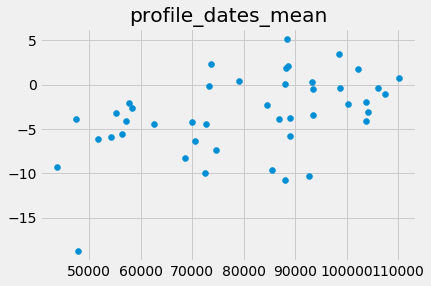

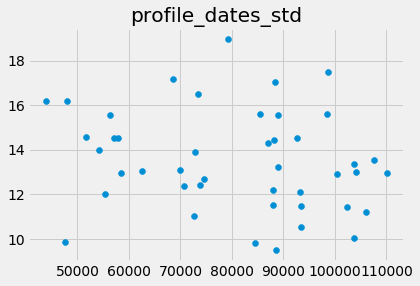

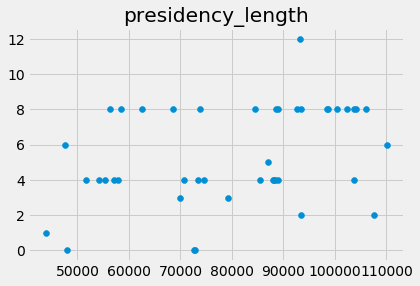

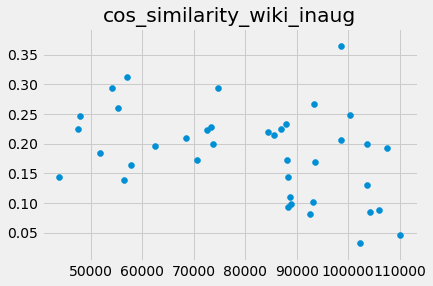

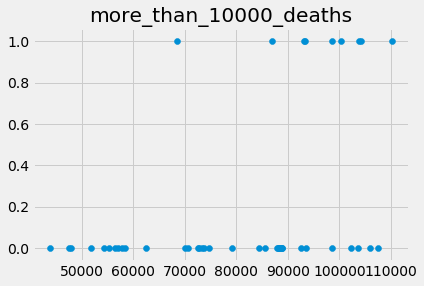

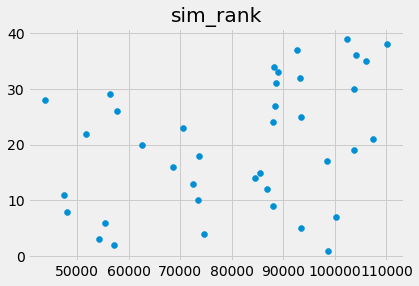

In [232]:
for col in df.select_dtypes(exclude=['object']).columns.tolist():
    if col != 'Words on Page':
        w = df.dropna(axis=0, subset=[col])
        plt.scatter(w['Words on Page'], w[col])
        plt.title(col)
        plt.show()
        plt.clf()

In [233]:
#getting google trend data from multiple csvs and concatting into one
path = './pres_trends_google/'
all_files = glob.glob(path + '*.csv')
to_concat = []

for file in all_files: 
    pres = pd.read_csv(file, header=1, index_col=0, na_values=['<1']).fillna('0.5')
    pres.columns = [re.findall(r'.+(?=:)', i)[0].title() for i in pres.columns]
    pres = pres.apply(pd.to_numeric)
    #pres = pres.replace({'<1':'0.5'}, regex=True)
    to_concat.append(pres)
    
trends = pd.concat(to_concat, axis=1)

#getting rid of duplicate George Washingtons
trends = trends.T.drop_duplicates(keep='last').reset_index().drop(28, axis=0).set_index('index')
#mean_trends to merge
mean_trends = trends.mean(axis=1).reset_index()
mean_trends.columns = ['name', 'mean_trend']
#fixing one out of order name and one capitalized incorrectly
mean_trends.iloc[4, 0] = 'Harrison2'
mean_trends.iloc[6, 0] = 'McKinley'

In [234]:
#getting column ready for merge
names_again = []
for name in df['President Name'].str.split().str[-1]:
    if name not in names_again:
        names_again.append(name)
    else:
        name = name + '2'
        names_again.append(name)

df['last_merge'] = names_again

        
names_again2 = []
for name in mean_trends['name'].str.split().str[-1]:
    if name not in names_again2:
        names_again2.append(name)
    else:
        name = name + '2'
        names_again2.append(name)

mean_trends['name'] = names_again2

#merging
df = pd.merge(df, mean_trends, left_on='last_merge', how='left', right_on='name')
df = df.drop(['last_merge', 'name'], axis=1)

In [235]:
df.to_csv('./with_mean_trend.csv')

In [240]:
trends.T.to_csv('./images/google_trends.csv')